In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

min_error = 0.000001

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
class AutoEncoder:
    def __init__(self, input_size, hidden_size, activation_function, previous=None, outputX=None, inputX=None):
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.tf_session = None

        self.weight_e = tf.Variable(tf.random_normal([input_size, hidden_size]))
        self.bias_e = tf.Variable(tf.random_normal([hidden_size]))

        if previous:
            self.previous = previous
        else:
            self.previous = None

        if inputX:
            self.inputX = inputX
        else:
            self.inputX = tf.placeholder('float', [None, input_size])

        if outputX!= None :
            self.outputX = outputX
        else:
            self.outputX = self.inputX

        self.activation_function = activation_function

        self.encoder = activation_function(tf.add(tf.matmul(self.inputX, self.weight_e), self.bias_e))

        self.weight_d = tf.transpose(self.weight_e)
        self.bias_d = tf.Variable(tf.random_normal([input_size]))

        self.decoder = activation_function(tf.add(tf.matmul(self.encoder, self.weight_d), self.bias_d))

    def set_weights_biases(self, weight_e, bias_e, bias_d, inputX=None):
        self.weight_e = weight_e
        self.weight_d = tf.transpose(weight_e)
        self.bias_e = bias_e
        self.bias_d = bias_d
        if inputX:
            self.encoder = self.activation_function(tf.add(tf.matmul(inputX, self.weight_e), self.bias_e))
        else:
            self.encoder = self.activation_function(tf.add(tf.matmul(self.inputX, self.weight_e), self.bias_e))

        self.decoder = self.activation_function(tf.add(tf.matmul(self.encoder, self.weight_d), self.bias_d))

    def get_trained_values(self, inputX=None):
        act_weight_e = tf.constant(self.tf_session.run(self.weight_e))
        act_bias_e = tf.constant(self.tf_session.run(self.bias_e))

        act_bias_d = tf.constant(self.tf_session.run(self.bias_d))

        act_auto_encoder = AutoEncoder(self.input_size, self.hidden_size, self.activation_function, self.previous)
        act_auto_encoder.set_weights_biases(act_weight_e, act_bias_e, act_bias_d, inputX)

        return act_auto_encoder

    def set_constants(self, inputX=None):
        self.weight_e = tf.constant(self.tf_session.run(self.weight_e))
        self.bias_e = tf.constant(self.tf_session.run(self.bias_e))
        if inputX:
            self.inputX = inputX

        self.encoder = self.activation_function(tf.add(tf.matmul(self.inputX, self.weight_e), self.bias_e))

        self.weight_d = tf.constant(self.tf_session.run(self.weight_d))
        self.bias_d = tf.constant(self.tf_session.run(self.bias_d))

        self.decoder = self.activation_function(tf.add(tf.matmul(self.encoder, self.weight_d), self.bias_d))

    def output(self, input_data, session=None):
        if session:
            self.tf_session = session

        if self.previous:
            input_data = self.previous.output(input_data, self.tf_session)

        return self.tf_session.run(self.encoder, feed_dict={self.inputX:input_data})

    def unsupervised_train(self, input_data, training_epochs=20, output_data = [], learning_rate=0.01, display_steps=10, batch_size=256):

        print(len(output_data))
        if len(output_data) == 0:
            y_pred = self.decoder
        else:
            y_pred = self.encoder
        y_true = self.outputX

        cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
        optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

        with tf.Session() as self.tf_session:

            input_size = len(input_data)
            self.tf_session.run(tf.global_variables_initializer())
            total_batch = int(input_size / batch_size)
            for epoch in range(training_epochs):
                start = time.time()
                count = 0
                cst = 0.0

                for i in range(total_batch):
                    end = count + batch_size
                    if end > input_size:
                        end = input_size

                    if self.previous:
                        batch_xs = self.previous.output(input_data[count:end], self.tf_session)
                    else:
                        batch_xs = input_data[count:end]

                    if len(output_data) == 0:
                        batch_ys = batch_xs
                    else:
                        batch_ys = output_data[count:end]

                    _, c = self.tf_session.run([optimizer, cost],
                                               feed_dict={self.inputX: batch_xs, self.outputX: batch_ys})
                    cst = cst + c
                    count = end

                cst = cst / total_batch
                if cst < min_error:
                    break

                end = time.time()
                if epoch % display_steps == 0:
                    print("Epoch:", '%04d' % (epoch + 1),
                          "cost=", "{:.9f}".format(cst))
                    print('epoch took {}'.format((end - start) * 1000))


            print("Optimization Finished!")

            self.set_constants()

            return self

In [4]:
def mergeLayers(layers):
    inputX = layers[0].inputX
    for layer in layers:
        inputX = layer.activation_function(tf.add(tf.matmul(inputX, layer.weight_e), layer.bias_e))

    layers.reverse()

    output = inputX
    for layer in layers:
        output = layer.activation_function(tf.add(tf.matmul(output, layer.weight_d), layer.bias_d))

    layers.reverse()
    return output, layers[0].inputX

def getEncoder(layers):
    inputX = layers[0].inputX
    for layer in layers:
        inputX = layer.activation_function(tf.add(tf.matmul(inputX, layer.weight_e), layer.bias_e))


    return inputX, layers[0].inputX

def finalLayer(layers):
    inputX = layers[0].inputX
    for layer in layers:
        weight = tf.Variable(layer.weight_e)
        bias = tf.Variable(layer.bias_e)
        inputX = layer.activation_function(tf.add(tf.matmul(inputX, weight), bias))

    return inputX, layers[0].inputX

In [5]:
def final_layer_train(encoder_pt, input_count, hidden_size, input_data, output_data, training_epochs=20, learning_rate=0.01, display_steps=10, batch_size=256):
    weight = tf.Variable(tf.random_normal([input_count, hidden_size]))
    bias = tf.Variable(tf.random_normal([hidden_size]))

    encoder = tf.nn.sigmoid(tf.add(tf.matmul(encoder_pt, weight), bias))

    y_true = outputX
    y_pred = encoder

    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

    input_size =len(input_data)

    with tf.Session() as def_session:
        def_session.run(tf.global_variables_initializer())
        for epoch in range(training_epochs):
            total_batch = int(input_size / batch_size)
            count = 0
            cst = 0.0
            for i in range(total_batch):
                end = count + batch_size
                if end > input_size:
                    end = input_size

                batch_xs = input_data[count:end]
                batch_ys = output_data[count:end]

                _, c = def_session.run([optimizer, cost],
                                       feed_dict={inputX: batch_xs, outputX: batch_ys})

                cst += c
                count = end
            cst = cst / total_batch
            if cst < min_error:
                break

            if epoch % display_steps == 0:
                print("Epoch:", '%04d' % (epoch + 1),
                      "cost=", "{:.9f}".format(cst))

        print("Optimization Finished!")

        correct_prediction = tf.equal(tf.argmax(encoder, 1), tf.argmax(outputX, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        print(def_session.run(accuracy, feed_dict={inputX: mnist.test.images, outputX: mnist.test.labels}))

In [6]:
%matplotlib inline

In [10]:
outputX = tf.placeholder('float', [None, 10])
layer1 = AutoEncoder(784, 256, tf.nn.sigmoid)
layer2 = AutoEncoder(256, 256, tf.nn.sigmoid, layer1)
layer3 = AutoEncoder(256, 128, tf.nn.sigmoid, layer2)
layer4 = AutoEncoder(128, 128, tf.nn.sigmoid, layer3)
layer5 = AutoEncoder(128, 64, tf.nn.sigmoid, layer4)
#layer4 = AutoEncoder(128, 10, tf.nn.sigmoid, layer3, outputX)


examples_to_show = 10

layers = []

layers.append(layer1.unsupervised_train(mnist.train.images, 160))
layers.append(layer2.unsupervised_train(mnist.train.images, 160))
layers.append(layer3.unsupervised_train(mnist.train.images, 160))
layers.append(layer4.unsupervised_train(mnist.train.images, 160))
layers.append(layer5.unsupervised_train(mnist.train.images, 160))
#layers.append(layer4.unsupervised_train(mnist.train.images, 320, mnist.train.labels))

decoder, input = mergeLayers(layers)

#encoder, inputX = getEncoder(layers)

encoder_pt, inputX = finalLayer(layers)

final_layer_train(encoder_pt, 64, 10, mnist.train.images, mnist.train.labels, 160)

0
Epoch: 0001 cost= 0.323615955
epoch took 480.81064224243164
Epoch: 0011 cost= 0.017427280
epoch took 454.42748069763184
Epoch: 0021 cost= 0.011717151
epoch took 441.5605068206787
Epoch: 0031 cost= 0.006579055
epoch took 415.0710105895996
Epoch: 0041 cost= 0.005870550
epoch took 424.389123916626
Epoch: 0051 cost= 0.005499998
epoch took 423.42400550842285
Epoch: 0061 cost= 0.004402456
epoch took 419.54731941223145
Epoch: 0071 cost= 0.004201958
epoch took 434.07678604125977
Epoch: 0081 cost= 0.004053602
epoch took 427.0622730255127
Epoch: 0091 cost= 0.003933523
epoch took 420.9177494049072
Epoch: 0101 cost= 0.003836908
epoch took 428.7271499633789
Epoch: 0111 cost= 0.003753360
epoch took 424.8161315917969
Epoch: 0121 cost= 0.003678475
epoch took 426.9289970397949
Epoch: 0131 cost= 0.002928707
epoch took 425.9626865386963
Epoch: 0141 cost= 0.002869032
epoch took 444.58723068237305
Epoch: 0151 cost= 0.002813421
epoch took 430.8643341064453
Optimization Finished!
0
Epoch: 0001 cost= 0.2330

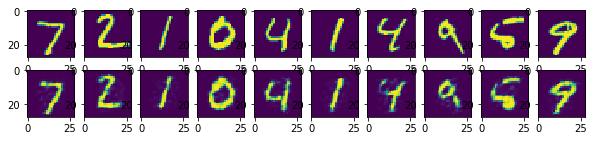

In [11]:
with tf.Session() as def_session:
    def_session.run(tf.global_variables_initializer())
    encode_decode = def_session.run(decoder, feed_dict={input:mnist.test.images[:examples_to_show]})

f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))